In [2]:
library(scatterplot3d)
library(repr)
library(kohonen)
library(heplots)
library(cluster)
library(MVN)
library(plotly)
library(klaR)
library(Morpho)
library(caret)
library(mclust)
library(ggplot2)
library(GGally)
library(plyr)
library(psych)
library(factoextra)
library(GPArotation)
library(RColorBrewer)
library(ggpubr)

options(repr.plot.width = 16, repr.plot.height = 12)

In [3]:
dataframe <- read.table('data.csv', header = TRUE,  sep = ',')
dataframe <- na.omit(dataframe)
head(dataframe)

,A,B,C,D,E,F,G,H,I,J,K,Name
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,57.60238,21.71322,51.65182,63.15491,47.50259,59.35368,8.753383,20.603756,6.491436,65.02040,8.078522,Dum
2,68.83134,24.31474,57.22687,62.42691,43.18839,51.63182,14.513575,73.935348,20.224595,74.94872,8.554909,Dum
3,26.39129,33.54387,97.81550,62.18773,12.46912,61.80452,33.145005,9.061499,26.646903,46.18950,11.804890,Albukerke
4,67.07043,78.42686,49.09763,48.87779,22.98881,47.41171,85.111717,41.587100,18.941216,64.50461,13.156304,Eugene
5,72.76105,48.36484,68.36730,44.16909,19.68516,68.10718,83.206047,52.037685,5.547961,74.68590,12.098432,Eugene
6,59.54595,78.88656,65.15747,21.71169,22.03904,64.93015,54.315721,71.587874,7.979146,73.80838,12.670125,Eugene


In [4]:
dataframe <- subset(dataframe, Name %in% c('Albukerke', 'Dum', 'Choluteco'), select = c(B, H, I, A, K, Name))
dataframe$Name <- as.factor(dataframe$Name)
head(dataframe)

,B,H,I,A,K,Name
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,21.71322,20.603756,6.491436,57.60238,8.078522,Dum
2,24.31474,73.935348,20.224595,68.83134,8.554909,Dum
3,33.54387,9.061499,26.646903,26.39129,11.804890,Albukerke
11,44.57927,57.869008,12.292205,81.15551,12.598837,Choluteco
12,22.87535,66.905280,4.261734,56.17829,9.602097,Dum
19,42.04710,55.827442,4.744516,75.64467,11.782264,Choluteco


In [5]:
summary(dataframe)

       B               H                  I                  A        
 Min.   :15.05   Min.   : 0.01963   Min.   : 0.01199   Min.   :25.00  
 1st Qu.:20.21   1st Qu.:14.63707   1st Qu.: 8.90383   1st Qu.:44.05  
 Median :25.66   Median :50.06950   Median :15.25803   Median :65.05  
 Mean   :29.25   Mean   :41.59317   Mean   :15.58264   Mean   :60.86  
 3rd Qu.:41.23   3rd Qu.:64.67229   3rd Qu.:22.04060   3rd Qu.:77.44  
 Max.   :44.99   Max.   :99.80861   Max.   :33.96930   Max.   :84.99  
       K                 Name    
 Min.   : 8.001   Albukerke:749  
 1st Qu.: 9.506   Choluteco:749  
 Median :10.949   Dum      :749  
 Mean   :10.664                  
 3rd Qu.:11.729                  
 Max.   :12.995                  

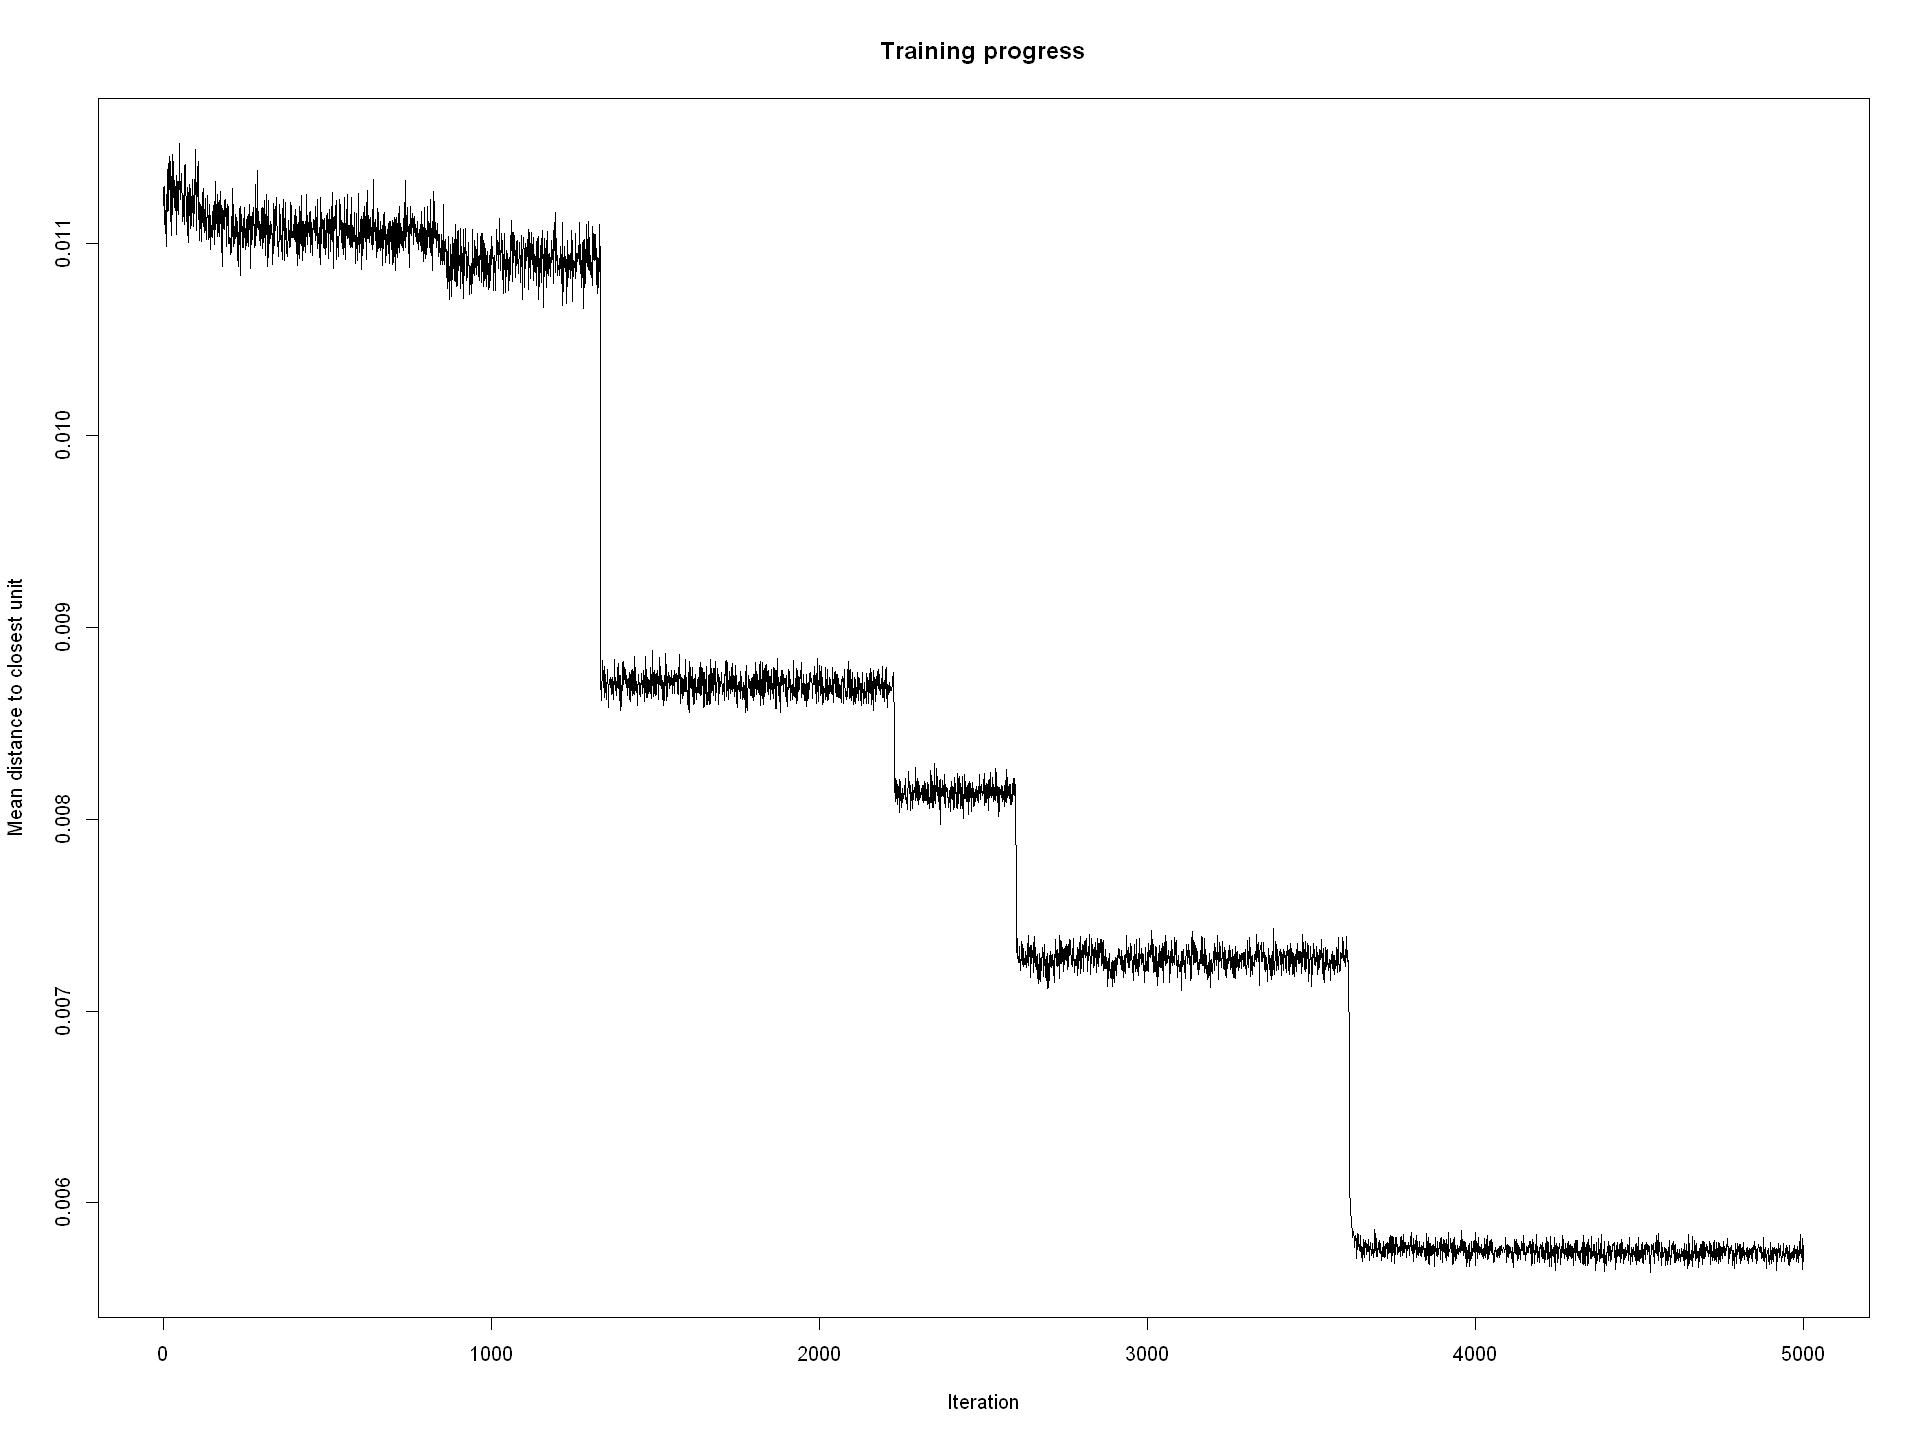

In [7]:
dataframe_train_matrix <- as.matrix(scale(dataframe[,1:5]))

set.seed(100)
som_grid = somgrid(xdim = 6, ydim = 6, topo = 'hexagonal')
som_model <- som(dataframe_train_matrix,
                 grid = som_grid,
                 rlen = 5000,
                 alpha = c(0.05, 0.01),
                 keep.data = TRUE)
plot(som_model, type = 'changes')

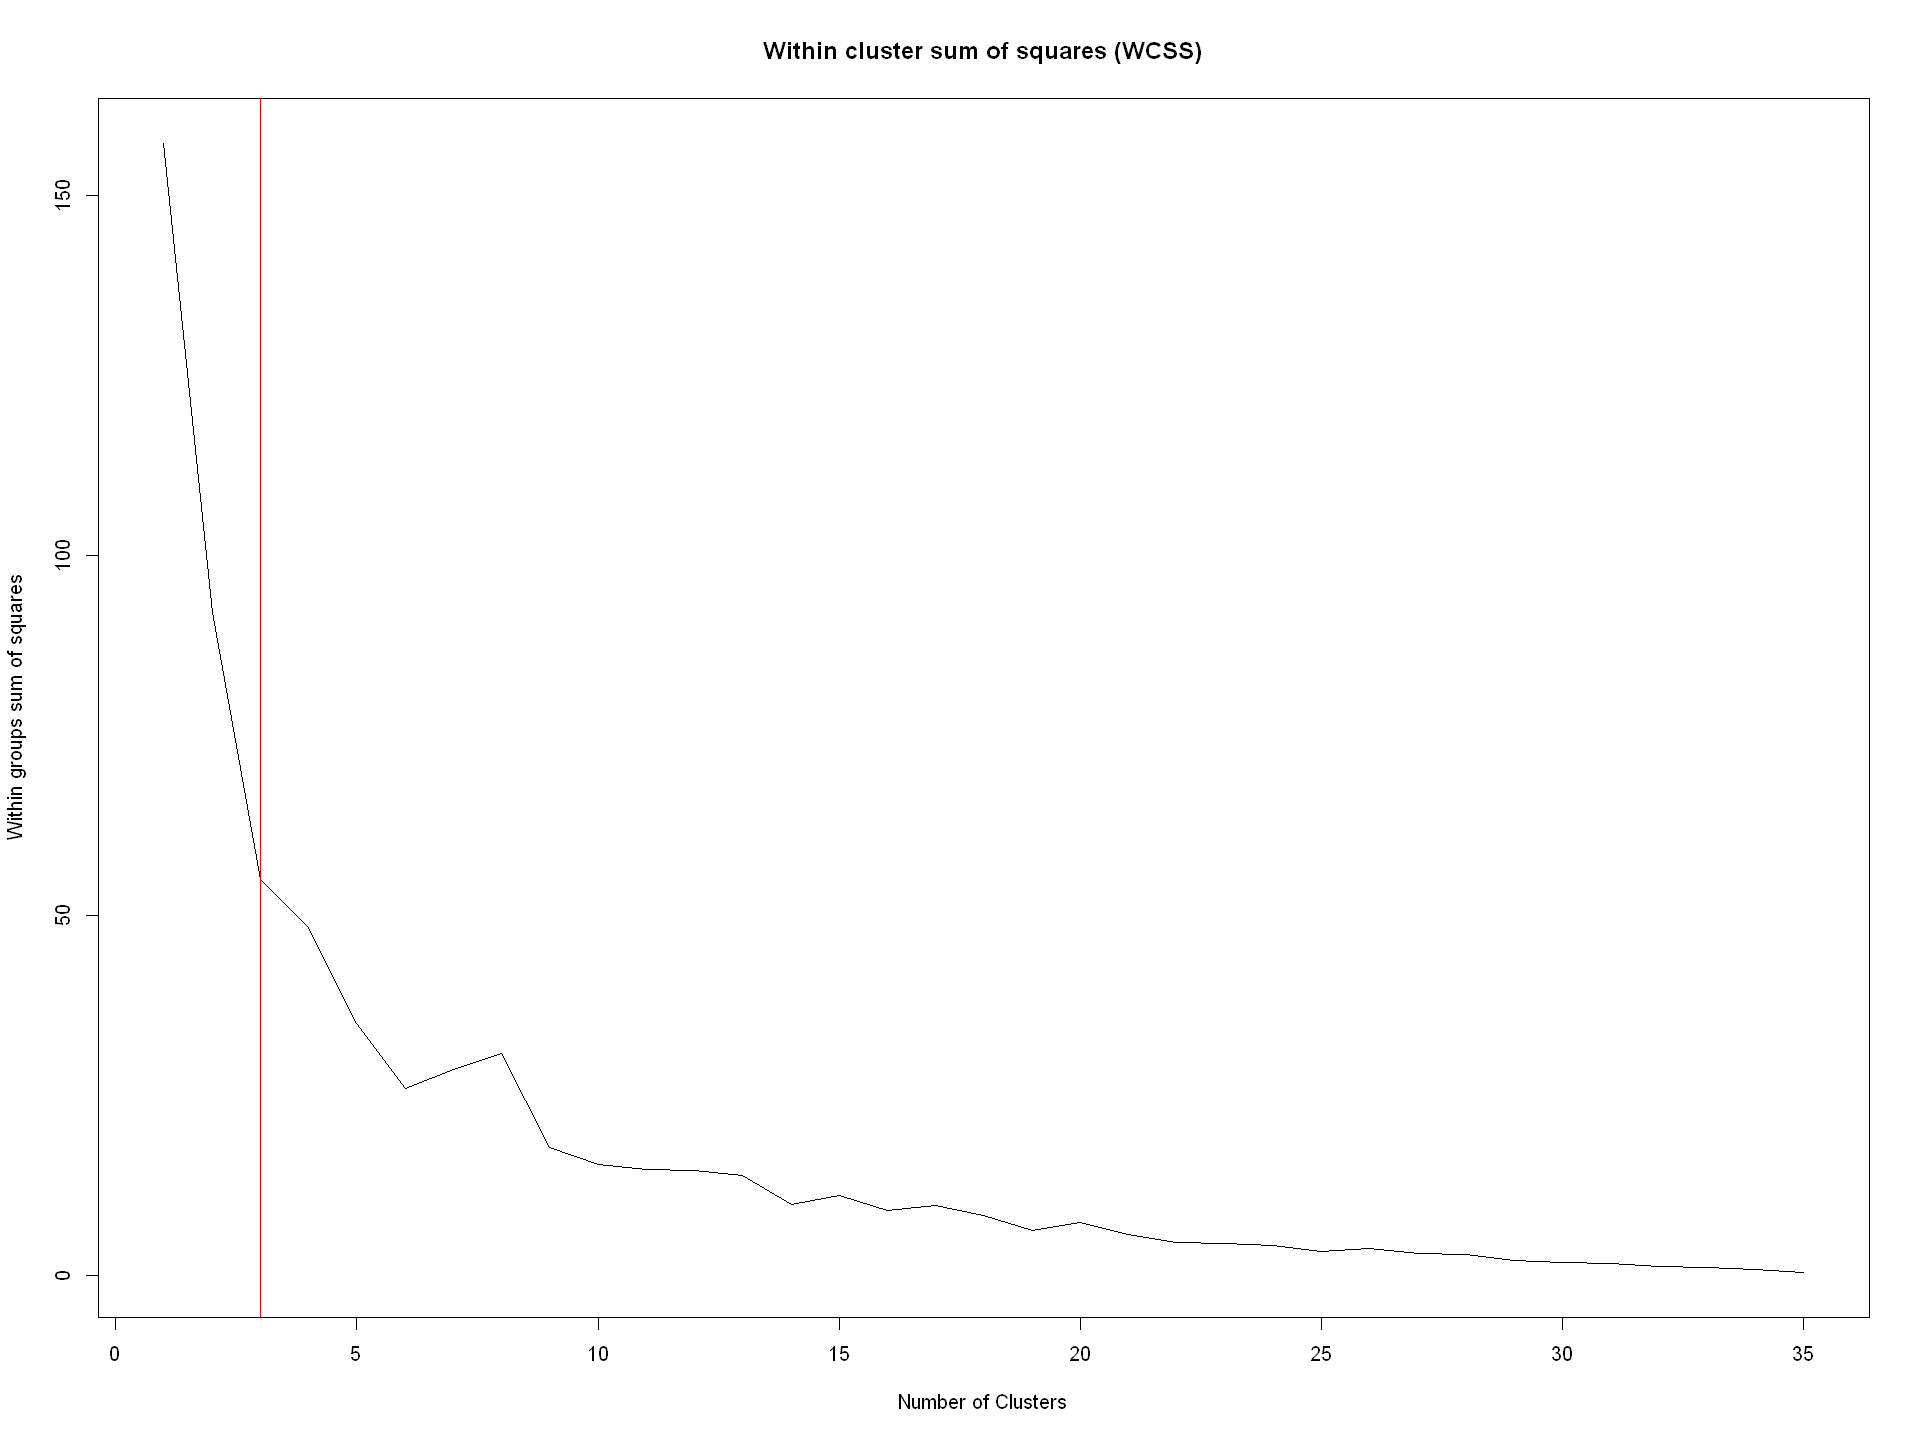

In [8]:
set.seed(100)
clusterdata <- getCodes(som_model)
wss <- (nrow(clusterdata) - 1) * sum(apply(clusterdata, 2, var))

for (i in 2:35) { #i must be less than 6*6 the grid size defined at the begining
  wss[i] <- sum(kmeans(clusterdata, centers = i)$withinss)
}

par(mar = c(5.1, 4.1, 4.1, 2.1))
plot(wss, type = 'l',
     xlab = 'Number of Clusters',
     ylab = 'Within groups sum of squares',
     main = 'Within cluster sum of squares (WCSS)')
abline(v = 3, col = 'red')

In [10]:
set.seed(100)
fit_kmeans <- kmeans(clusterdata[,1:5], 3)
cl_assignment_k <- fit_kmeans$cluster[som_model$unit.classif] 
#The above is to assign units to clusters based on their class-id (code-id) in the SOM model.
dataframe$clustersKm <- cl_assignment_k #back to original data.

dataframe$trueN <- ifelse(dataframe$Name == 'Baxan',
                          1,
                          ifelse(dataframe$Name == 'Choluteco',
                                 2,
                                 ifelse(dataframe$Name == 'Eugene',
                                        3,
                                        NA
                                       )
                                )
                         )

head(dataframe)
dataframe$testkm <- 1 #make everything "wrong" (i.e. 1).
#Cluster assignments can only be right in one whay, but wrong in k (no of clusters-1) ways.
#Better look for the "rights", rather than the "wrongs".
dataframe$testkm[dataframe$clustersKm == 2 & dataframe$trueN == 1] <- 0 #Make 2 right, i.e. 0.
dataframe$testkm[dataframe$clustersKm == 3 & dataframe$trueN == 2] <- 0 #3 was right for true 2.
dataframe$testkm[dataframe$clustersKm == 1 & dataframe$trueN == 3] <- 0 #1 was righht for true 3.
testKM <- sum(dataframe$testkm)
as.matrix(list(accurancy = 1 - (testKM / 36)))

,B,H,I,A,K,Name,clustersKm,trueN
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<int>,<dbl>
1,21.71322,20.603756,6.491436,57.60238,8.078522,Dum,2,NA
2,24.31474,73.935348,20.224595,68.83134,8.554909,Dum,2,NA
3,33.54387,9.061499,26.646903,26.39129,11.804890,Albukerke,1,NA
11,44.57927,57.869008,12.292205,81.15551,12.598837,Choluteco,3,2
12,22.87535,66.905280,4.261734,56.17829,9.602097,Dum,2,NA
19,42.04710,55.827442,4.744516,75.64467,11.782264,Choluteco,3,2


accurancy,-40.61111


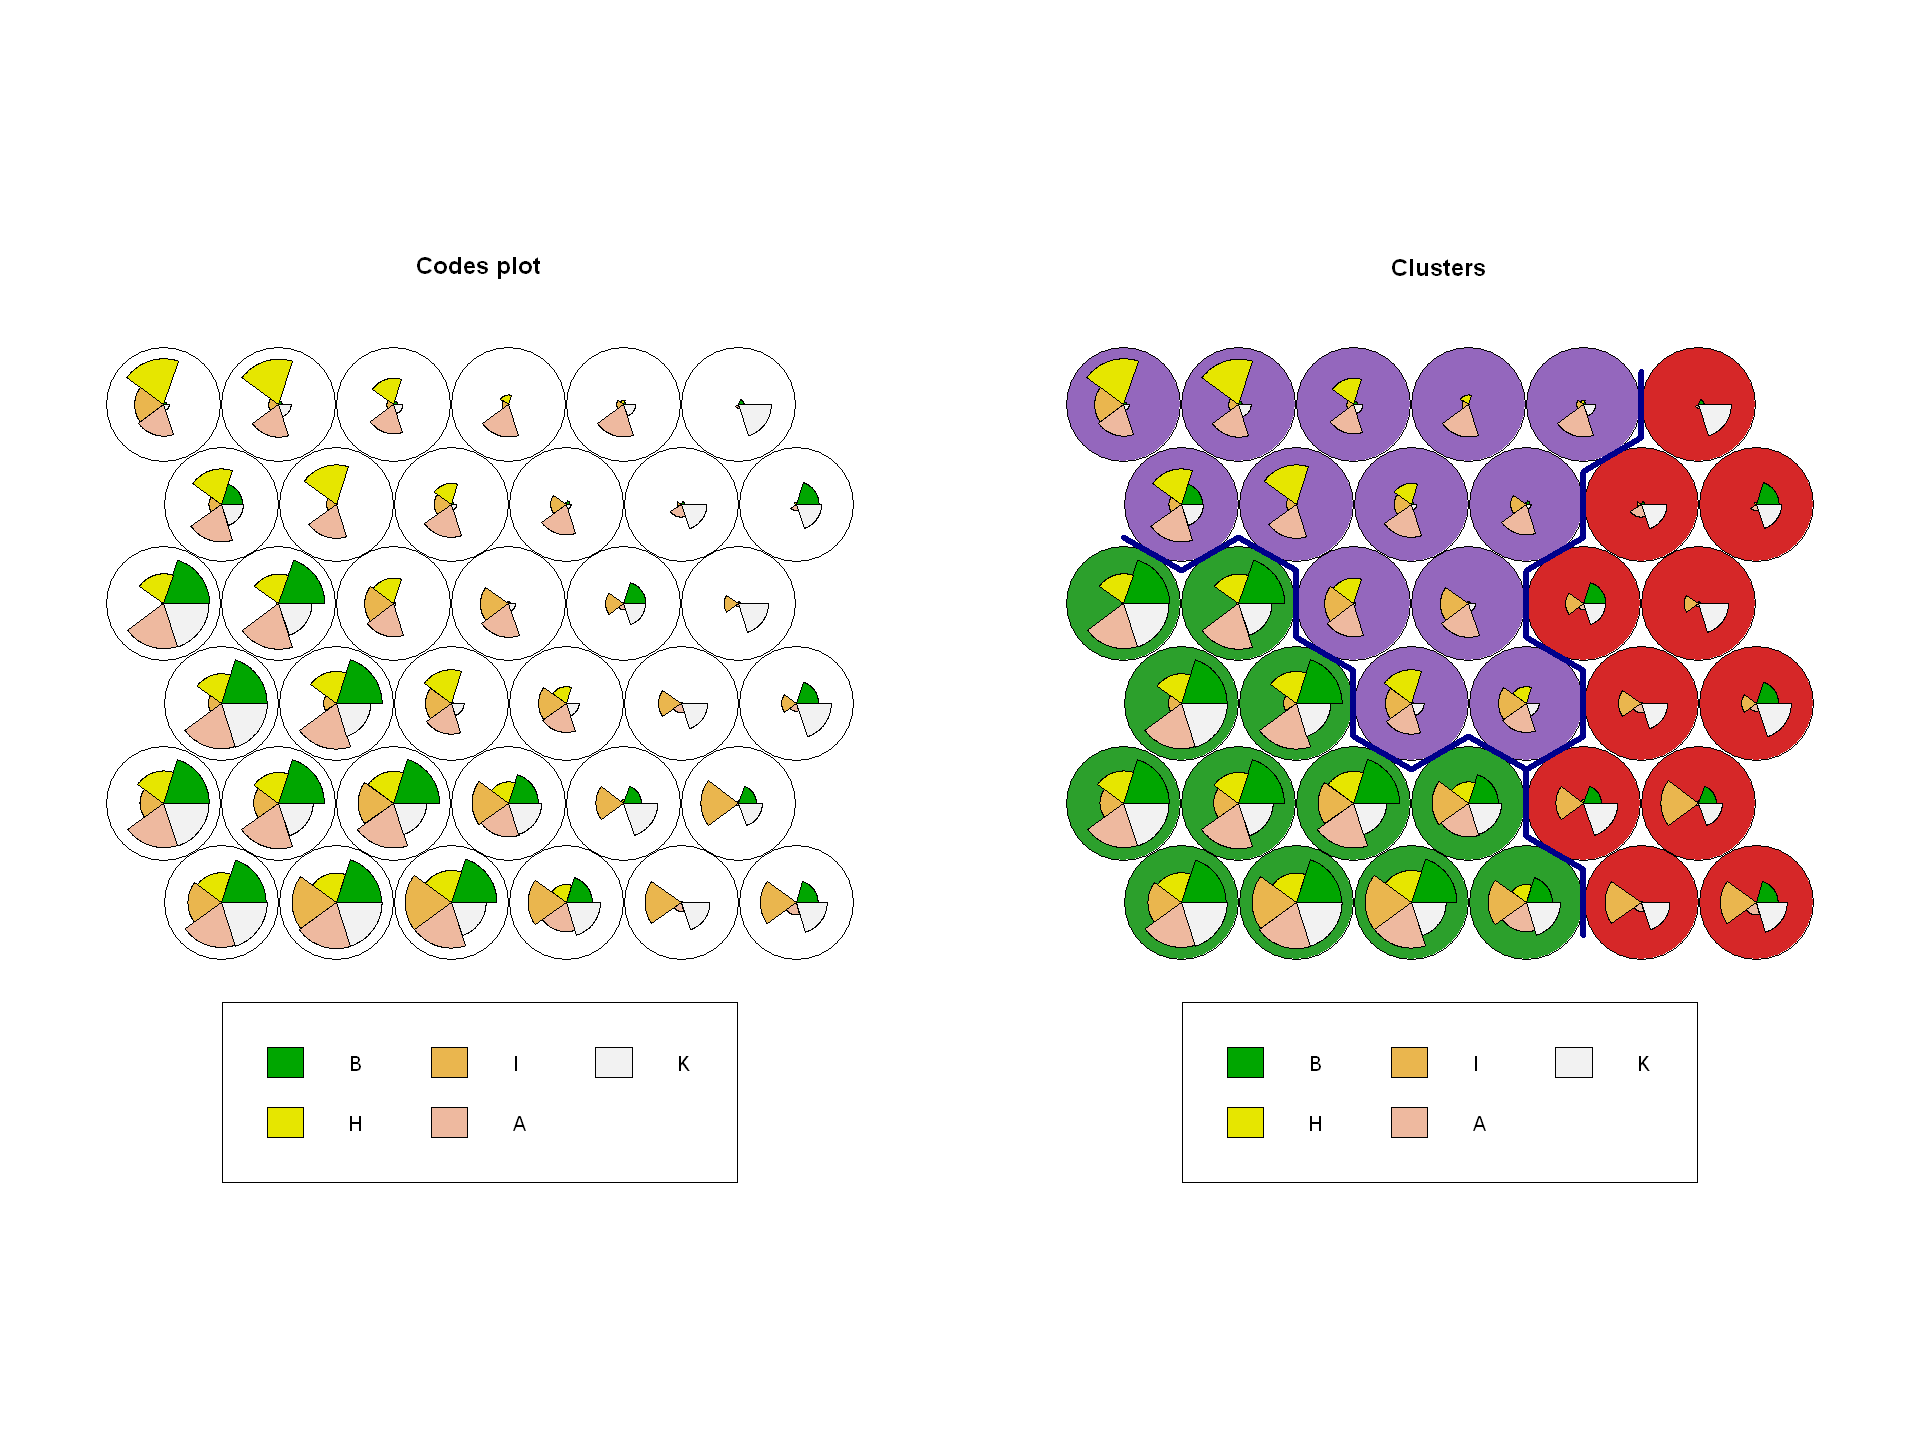

In [11]:
som_cluster <- cutree(hclust(dist(clusterdata)), k = 3)

palette <- c('#2ca02c', '#d62728', '#9467bd')

par(mfrow = c(1,2))
plot(som_model, type = 'codes') 
plot(som_model, type = 'codes', bgcol = palette[som_cluster], main = 'Clusters') 
add.cluster.boundaries(som_model, som_cluster, col = 'darkblue')